# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [4]:
tab = pd.crosstab(df['sex'], df['flag_doente'], margins= True)
tab = tab.rename(columns={0: 'saudaveis', 1: 'doentes', 'All': 'total'})

tab['media_doentes'] = tab['doentes'] / tab['total']
tab.index = tab.index.map({0: 'female', 1: 'male', 'All': 'total'})
tab['odds'] = tab['doentes']/tab['saudaveis']
tab['odds_ratio'] = tab['odds']/tab.loc['total','odds']
tab['logito'] = np.log(tab['odds'])
tab['WOE'] = np.log(tab['odds_ratio'])
tab

flag_doente,saudaveis,doentes,total,media_doentes,odds,odds_ratio,logito,WOE
sex,,,,,,,,
female,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
male,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [5]:
def bivariada_logit(df, resposta, explicativa):
# Tabela de frequências com totais
    tab = pd.crosstab(df[explicativa], df[resposta], margins=True)
    tab = tab.rename(columns={0: 'saudaveis', 1: 'doentes', 'All': 'total'})
    
# Média de doentes
    tab['media_doentes'] = tab['doentes'] / tab['total']
    
# Cálculando odds
    tab['odds'] = tab['doentes'] / tab['saudaveis']
    
# Odds ratio: comparar com a média total
    if tab.loc['All', 'doentes'] != 0 and tab.loc['All', 'saudaveis'] != 0:
        odds_total = tab.loc['All', 'doentes'] / tab.loc['All', 'saudaveis']
        tab['odds_ratio'] = tab['odds'] / odds_total
    else:
        tab['odds_ratio'] = np.nan
    
# Logito e Weight of Evidence (WOE)
    tab['logito'] = np.log(tab['odds'])
    tab['WOE'] = np.log(tab['odds_ratio'])
    
# Renomeando índice para evitar "All"
    tab = tab.rename(index={'All': 'total'})
    
    return tab

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [6]:
def bivariada_logit_continua(df, resposta, explicativa, num_categorias=5):
# Criando categorias com base em quantis (distribuição balanceada)
    df[f'{explicativa}_cat'] = pd.qcut(df[explicativa], q=num_categorias, duplicates='drop')

# Reaproveitando a função da bivariada qualitativa
    tab = pd.crosstab(df[f'{explicativa}_cat'], df[resposta], margins=True)
    tab = tab.rename(columns={0: 'saudaveis', 1: 'doentes', 'All': 'total'})

    tab['media_doentes'] = tab['doentes'] / tab['total']
    tab['odds'] = tab['doentes'] / tab['saudaveis']
    
    if tab.loc['All', 'doentes'] != 0 and tab.loc['All', 'saudaveis'] != 0:
        odds_total = tab.loc['All', 'doentes'] / tab.loc['All', 'saudaveis']
        tab['odds_ratio'] = tab['odds'] / odds_total
    else:
        tab['odds_ratio'] = np.nan

    tab['logito'] = np.log(tab['odds'])
    tab['WOE'] = np.log(tab['odds_ratio'])
    
    tab = tab.rename(index={'All': 'total'})

    return tab

3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [11]:
# Padronizando as variáveis contínuas
scaler = StandardScaler()
df[['age_scaled', 'trestbps_scaled']] = scaler.fit_transform(df[['age', 'trestbps']])

formula = 'flag_doente ~ C(sex) + C(cp) + trestbps_scaled + age_scaled'

modelo = smf.logit(formula=formula, data=df).fit(method='lbfgs', maxiter=200)
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Tue, 28 Oct 2025   Pseudo R-squ.:                  0.3097
Time:                        21:15:30   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.7185      0.604     -4.504      0.000      -3.901      -1.536
C(sex)[T.1.0]       1.8094      0.353      5.130      0.000       1.118       2.501
C(cp)[T.2.0]       -0.0617      0.636     -0.097      0.923      -1.309       1.186
C(cp)[T.3.0]        0.0715      0.573      0.125      0.901      -1.051       1.194
C(cp)[T.4.0]        2.4789      0.553      4.485      0.000       1.396       3.562
trestbps_scaled     0.3387      0.150      2.261      0.024       0.045       0.632
age_scaled          0.5112      0.164      3.120      0.002       0.190       0.832
===================================================================================
"""

- Variável ``sex``:
  
Coeficiente positivo indica que homens têm maior risco de doença cardíaca em relação às mulheres.

Odds Ratio = exp(1.8094) ≈ 6.11

🔹 Homens têm aproximadamente 6 vezes mais chance de apresentar doença cardíaca do que mulheres, mantendo as demais variáveis constantes

- Variável ``cp``:
  
A única categoria realmente importante é cp = 4 (assintomático):

Odds Ratio = exp(2.4979) ≈ 12.15

🔹 Pacientes assintomáticos têm cerca de 12 vezes mais chances de ter doença cardíaca em comparação com quem tem angina típica.

As outras categorias não têm efeito estatisticamente diferente da referência.

- Variável ``trestbps_scaled``:

Pressão arterial em repouso não teve efeito estatisticamente relevante no risco de doença, após ajustarmos pelas outras variáveis.

Conclusão: Não contribui muito para o modelo.

- Variável ``age_acaled``

Como a variável foi padronizada, esse coeficiente representa o efeito de 1 desvio padrão no aumento da idade.

Odds Ratio = exp(0.5112) ≈ 1.67
🔹 A cada aumento de 1 desvio padrão na idade, a chance de ter doença cardíaca aumenta em aproximadamente 67%, mantendo as outras variáveis constantes.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [13]:
# Calculando a probabilidade prevista
df['prob_predita'] = modelo.predict()

# Categorizando em 5 grupos com base nos quantis
df['grupo_prob'] = pd.qcut(df['prob_predita'], q=5, labels=False)

# Calculando a média da probabilidade predita e a taxa observada por grupo
tabela_calibragem = df.groupby('grupo_prob').agg(
    prob_predita_media = ('prob_predita', 'mean'),
    taxa_observada = ('flag_doente', 'mean'),
    quantidade = ('flag_doente', 'count')
).reset_index()

print("Tabela de Calibragem (Esperado vs Observado):")
display(tabela_calibragem)

Tabela de Calibragem (Esperado vs Observado):


,grupo_prob,prob_predita_media,taxa_observada,quantidade
0,0,0.072003,0.080645,62
1,1,0.209618,0.152542,59
2,2,0.435164,0.483871,62
3,3,0.708853,0.762712,59
4,4,0.874818,0.819672,61


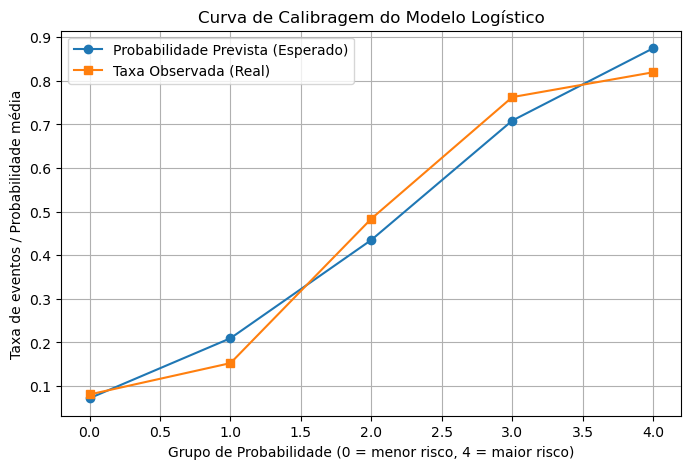

In [14]:
# Gráfico de comparação
plt.figure(figsize=(8,5))
plt.plot(tabela_calibragem['grupo_prob'], tabela_calibragem['prob_predita_media'], marker='o', label='Probabilidade Prevista (Esperado)')
plt.plot(tabela_calibragem['grupo_prob'], tabela_calibragem['taxa_observada'], marker='s', label='Taxa Observada (Real)')
plt.xlabel('Grupo de Probabilidade (0 = menor risco, 4 = maior risco)')
plt.ylabel('Taxa de eventos / Probabilidade média')
plt.title('Curva de Calibragem do Modelo Logístico')
plt.legend()
plt.grid(True)
plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [16]:
# Calculando a probabilidade predita
df['prob_predita'] = modelo.predict()

# Criando a classificação binária com limite de 0.5 (padrão)
df['classe_predita'] = (df['prob_predita'] >= 0.5).astype(int)

# Acurácia
acuracia = accuracy_score(df['flag_doente'], df['classe_predita'])

# AUC e GINI
auc = roc_auc_score(df['flag_doente'], df['prob_predita'])
gini = 2 * auc - 1

# Cálculo do KS
fpr, tpr, thresholds = roc_curve(df['flag_doente'], df['prob_predita'])
ks = max(tpr - fpr)

print(f"Acurácia: {acuracia:.4f}")
print(f"AUC: {auc:.4f}")
print(f"GINI: {gini:.4f}")
print(f"KS: {ks:.4f}")

Acurácia: 0.7954
AUC: 0.8519
GINI: 0.7039
KS: 0.5930


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [18]:
formula_melhor = 'flag_doente ~ C(sex) + C(cp) + age_scaled + C(exang) + oldpeak'
modelo_melhor = smf.logit(formula=formula_melhor, data=df).fit(method="lbfgs", maxiter=200)
modelo_melhor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            7
Date:                Tue, 28 Oct 2025   Pseudo R-squ.:                  0.3874
Time:                        21:54:15   Log-Likelihood:                -128.03
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.259e-31
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.7368      0.689     -5.423      0.000      -5.087      -2.386
C(sex)[T.1.0]       1.6626      0.376      4.416      0.000       0.925       2.400
C(cp)[T.2.0]        0.7085      0.685      1.034      0.301      -0.634       2.051
C(cp)[T.3.0]        0.2214      0.607      0.365      0.715      -0.968       1.411
C(cp)[T.4.0]        2.2926      0.592      3.872      0.000       1.132       3.453
C(exang)[T.1.0]     1.0270      0.355      2.894      0.004       0.332       1.722
age_scaled          0.4965      0.168      2.957      0.003       0.167       0.825
oldpeak             0.7583      0.169      4.487      0.000       0.427       1.090
===================================================================================
"""

In [20]:
def avaliar_modelo(modelo, nome):
    df['prob_predita'] = modelo.predict()
    df['classe_predita'] = (df['prob_predita'] >= 0.5).astype(int)
    
    auc = roc_auc_score(df['flag_doente'], df['prob_predita'])
    gini = 2 * auc - 1
    fpr, tpr, _ = roc_curve(df['flag_doente'], df['prob_predita'])
    ks = max(tpr - fpr)
    acuracia = accuracy_score(df['flag_doente'], df['classe_predita'])
    
    print(f"\n===== {nome} =====")
    print(f"Acurácia: {acuracia:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"GINI: {gini:.4f}")
    print(f"KS: {ks:.4f}")
    
avaliar_modelo(modelo, "Modelo Base")
avaliar_modelo(modelo_melhor, "Modelo Melhorado")


===== Modelo Base =====
Acurácia: 0.7954
AUC: 0.8519
GINI: 0.7039
KS: 0.5930

===== Modelo Melhorado =====
Acurácia: 0.8251
AUC: 0.8850
GINI: 0.7699
KS: 0.6450
